In [87]:
# This case study download WaPOR NPP data in 2024 for the EcoID 728, after download the data, 
# mosaic the data, clip the data with ECOID 728 and present one of the final image
# Created by Pengyu Hao (pengyu.hao@fao.org) on 2026/1/21 
import glob
import rasterio
import fiona
import numpy as np
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [88]:
#get all the datasets from the data path
path_raw = "/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/"
datalist = glob.glob(path_raw + "*.tif")
datalist.sort()
#print(datalist)

In [89]:
#get all time phases from the data list
timephase = []
for item in datalist:
    #print(item)
    index = item.find(".tif")
    time = item[index-10:index]
    if time in timephase:
        continue
    timephase.append(time)
print(timephase)    

['2024-01-D1', '2024-01-D2', '2024-01-D3', '2024-02-D1', '2024-02-D2', '2024-02-D3', '2024-03-D1', '2024-03-D2', '2024-03-D3', '2024-04-D1', '2024-04-D2', '2024-04-D3', '2024-05-D1', '2024-05-D2', '2024-05-D3', '2024-06-D1', '2024-06-D2', '2024-06-D3', '2024-07-D1', '2024-07-D2', '2024-07-D3', '2024-08-D1', '2024-08-D2', '2024-08-D3', '2024-09-D1', '2024-09-D2', '2024-09-D3', '2024-10-D1', '2024-10-D2', '2024-10-D3', '2024-11-D1', '2024-11-D2', '2024-11-D3', '2024-12-D1', '2024-12-D2', '2024-12-D3']


In [90]:
# define a function to find element in a list of string
def target_sublist(datalist, target):
    list_select = []
    #target = '2024-01-D1'
    for tmp in datalist:
        if target in tmp:
            list_select.append(tmp)
    return list_select

# mosaic the data of each time phase and output
path_mosaic = "/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/mosaic/"
for time in timephase:
    sublist = target_sublist(datalist, time)
    print(sublist)
    file_mosaic = path_mosaic + "WAPOR-3.L1-UTM-NPP-D" + time + ".tif"
    #target crs for the mosaic
    target_crs = "EPSG:3857"
    datasets = []
    try:
        for path in sublist:
            src = rasterio.open(path)

            # If already in EPSG:3857, keep as-is
            if src.crs and src.crs.to_string() == target_crs:
                datasets.append(src)
                continue

            # Calculate target transform
            transform, width, height = calculate_default_transform(
                src.crs,
                target_crs,
                src.width,
                src.height,
                *src.bounds
            )

            meta = src.meta.copy()
            meta.update({
                "crs": target_crs,
                "transform": transform,
                "width": width,
                "height": height
            })

            # Reproject in memory
            memfile = MemoryFile()
            with memfile.open(**meta) as dst:
                for band in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, band),
                        destination=rasterio.band(dst, band),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=target_crs,
                        resampling=Resampling.nearest
                    )
            datasets.append(memfile.open())

        # Mosaic all reprojected datasets
        mosaic, transform = merge(datasets)

        # Output metadata
        meta = datasets[0].meta.copy()
        meta.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": transform,
            "driver": "GTiff",
            "crs": target_crs
        })

        with rasterio.open(file_mosaic, "w", **meta) as dst:
            dst.write(mosaic)

    finally:
        for ds in datasets:
            ds.close()

    

['/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.44T.2024-01-D1.tif', '/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.45T.2024-01-D1.tif']
['/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.44T.2024-01-D2.tif', '/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.45T.2024-01-D2.tif']
['/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.44T.2024-01-D3.tif', '/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.45T.2024-01-D3.tif']
['/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.44T.2024-02-D1.tif', '/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.45T.2024-02-D1.tif']
['/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.44T.2024-02-D2.tif', '/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/raw/WAPOR-3.L1-UTM-NPP-D.45T.2024-02-D2.t

In [91]:
# using EcoID 728 boundary to clip all NPP data
shp_file = "/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/shp/Ecoregion_ID_728_Export.shp"
shp_reproject = "/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/shp/Ecoregion_ID_728_Reproject.shp"

# Read shapefile
gdf = gpd.read_file(shp_file)
# Reproject to EPSG:3857
gdf_3857 = gdf.to_crs(epsg=3857)
# Write output
gdf_3857.to_file(shp_reproject)

#read the reprojected shpfile
shp = fiona.open(shp_reproject)
feature = shp[0]
geom = feature['geometry']
print(feature)
path_clip = "/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/"
mosaic_files = glob.glob(path_mosaic + "*.tif")
for file in mosaic_files:
    index = file.rfind("/")
    name = file[index+1:]
    raster_tmp = rasterio.open(file)
    output_raster_path = path_clip + name
    print(output_raster_path)
    out_tmp_image, out_transform = mask(raster_tmp,[geom],crop=True)
    # Update the metadata of the output raster
    out_meta = raster_tmp.meta.copy()
    out_meta.update({
        'height': out_tmp_image.shape[1],
        'width': out_tmp_image.shape[2],
        'transform': out_transform
    })

    with rasterio.open(output_raster_path, 'w', **out_meta) as dest:
        dest.write(out_tmp_image)

fiona.Feature(geometry=fiona.Geometry(coordinates=[[(8925810.853012001, 5902263.340091013), ...]], type='Polygon'), id='0', properties=fiona.Properties(BIOME_NUM=8.0, ECO_BIOME_='PA08', BIOME_NAME='Temperate Grasslands, Savannas & Shrublands', NNH=3, REALM='Palearctic', SHAPE_AREA=7.59403598652, OBJECTID=251.0, COLOR_NNH='#F9A91B', COLOR_BIO='#FEFF73', COLOR='#FD9057', ECO_NAME='Emin Valley steppe', SHAPE_LENG=18.5212925282, ECO_ID=728, LICENSE='CC-BY 4.0', NNH_NAME='Nature Could Recover'))
/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/WAPOR-3.L1-UTM-NPP-D2024-02-D1.tif
/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/WAPOR-3.L1-UTM-NPP-D2024-07-D2.tif
/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/WAPOR-3.L1-UTM-NPP-D2024-05-D3.tif
/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/WAPOR-3.L1-UTM-NPP-D2024-10-D3.tif
/home/pengyu_hao_fao_org/RSP_test/NPP_test/WaPOR-NPP/clip/WAPOR-3.L1-UTM-NPP-D2024-03-D1.tif
/home/pengyu_hao_fao_org/RSP_test/NPP_t

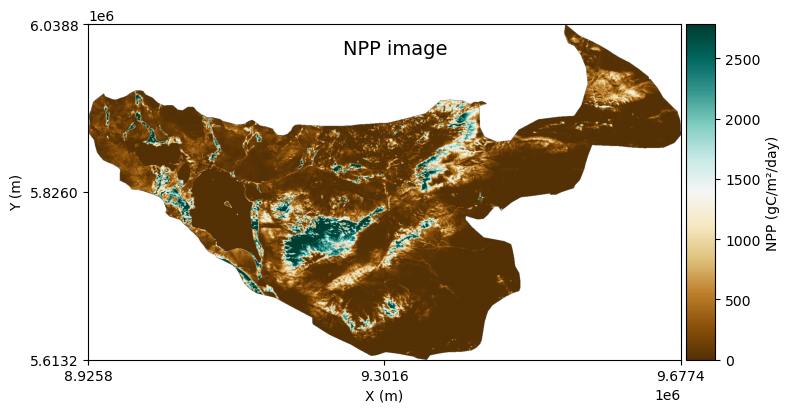

In [92]:
NPP_clip_list = glob.glob(path_clip + "*.tif")
NPP_clip_0 = NPP_clip_list[20]

with rasterio.open(NPP_clip_0) as src:
    data = src.read(1)
    nodata = src.nodata

    # Mask NoData
    if nodata is not None:
        data = np.ma.masked_equal(data, nodata)

    # 2% percentile stretch
    vmin, vmax = np.percentile(data.compressed(), [2, 98])

    # Spatial extent (meters)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Raster plot
im = ax.imshow(
    data,
    extent=extent,
    origin="upper",
    cmap="BrBG",
    vmin=vmin,
    vmax=vmax
)

# Axis labels
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# Three ticks per axis
ax.set_xticks([extent[0], (extent[0] + extent[1]) / 2, extent[1]])
ax.set_yticks([extent[2], (extent[2] + extent[3]) / 2, extent[3]])

# Full-height colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("NPP (gC/m²/day)")

# Title at top of figure
fig.suptitle("NPP image", fontsize=14, y=0.65)

# Leave room for the title
fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()